In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import copy
import gzip
import networkx as nx


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

plt.style.use('themes/rose-pine-moon.mplstyle')


%config InlineBackend.figure_format='svg'

In [2]:
# Load the data
data = pd.read_feather('data/temp/data.feather')

In [3]:
print(len(data))
data.head()


1821316


,date,primaryTime,emulated,name,releaseDate,name_category,name_user,location,platform_name
8,2021-12-22,449.533,False,RE:RUN,2020-08-08,Any%,quebecpower,ca/qc,PC
9,2019-02-09,194.000,False,Time Warpers,2018-11-02,Zones 1-100,_zuR,br,PC
11,2014-11-17,857.000,True,Kirby's Dream Land,1992-04-27,Normal Mode,SapphireYoshi,us,Game Boy
12,2014-11-17,3062.000,False,Kirby: Nightmare in Dream Land,2002-10-25,Any%,SapphireYoshi,us,Game Boy Advance
13,2014-11-17,2454.000,False,Kirby & The Amazing Mirror,2004-04-15,Any%,SapphireYoshi,us,Game Boy Advance


In [4]:
# Find the games ("name") with the most submissions, and keep the top 100, along with their release date and platform
top_games = data[["name", "name_category"]].value_counts()

# Same for time on leaderboard in 2023
data_2023 = data[data["date"] >= '2023-01-01']
top_games_2023 = data_2023[["name", "name_category"]].value_counts()

# Convert the index to columns
top_games = top_games.reset_index()
top_games_2023 = top_games_2023.reset_index()

# For each game, find the first release date and platform
top_games_data = data[data["name"].isin(top_games["name"])].groupby(["name", "name_category"]).agg(
    {"releaseDate": "first", "platform_name": "first"}
)
top_games_data_2023 = data_2023[data_2023["name"].isin(top_games_2023["name"])].groupby(["name", "name_category"]).agg(
    {"releaseDate": "first", "platform_name": "first"}
)

# Add count of submissions for each game and category in the top games
top_games_data = top_games_data.join(data[["name", "name_category"]].value_counts(), on=["name", "name_category"])

# Same for 2023
top_games_data_2023 = top_games_data_2023.join(data_2023[["name", "name_category"]].value_counts(), on=["name", "name_category"])

# Add sum of all submissions for each game in the top games
top_games_data["sum_count"] = top_games_data["count"].groupby("name").transform("sum")

# Same for 2023
top_games_data_2023["sum_count"] = top_games_data_2023["count"].groupby("name").transform("sum")

# Only keep the top 3 count of submissions for each game...
# First sort by count of submissions (descending) for each game
top_games_data = top_games_data.sort_values("count", ascending=False)
top_games_data_2023 = top_games_data_2023.sort_values("count", ascending=False)
# ... then keep the top 3 for each game
#top_games_data = top_games_data.groupby("name").head(3)

# Sort by count of submissions (descending)
top_games_data = top_games_data.sort_values(["sum_count", "count"], ascending=False)
top_games_data_2023 = top_games_data_2023.sort_values(["sum_count", "count"], ascending=False)

# Remove any rown that have NaN or None
top_games_data = top_games_data.dropna()
top_games_data_2023 = top_games_data_2023.dropna()

# Reset the index
top_games_data = top_games_data.reset_index()
top_games_data_2023 = top_games_data_2023.reset_index()


top_50_games_data_names = top_games_data.drop_duplicates(subset=["name"]).head(50)



In [5]:
# Get the list of users for each game in the top 50
users_per_game = (
    data[data["name"].isin(top_50_games_data_names.name)].groupby("name")["name_user"].unique()
)

dic_game_id = {game: game for i, game in enumerate(users_per_game.index)}
dic_id_game = {game: game for i, game in enumerate(users_per_game.index)}

# Create a dictionary with the number of users that have submitted runs for both games
graph_data = {}
for game1 in users_per_game.index:
    for game2 in users_per_game.index:
        if game1 != game2:
            weight = len(set(users_per_game[game1]).intersection(set(users_per_game[game2])))
            if weight > 0:
                graph_data[(dic_game_id[game1], dic_game_id[game2])] = weight

# Create a graph with the data
G = nx.Graph()
for key, value in graph_data.items():
    G.add_edge(key[0], key[1], weight=value)

def scale_saturate(value):
    scaled_value = 0
    for i in range(value):
        if i<10:
            scaled_value += 1
        elif i<50:
            scaled_value += 0.5
        elif i<200:
            scaled_value += 0.25
        else:
            scaled_value += 0.1
    return scaled_value

def scale_saturate_less(value):
    scaled_value = 0
    for i in range(value):
        if i<10:
            scaled_value += 1
        elif i<50:
            scaled_value += 0.8
        elif i<200:
            scaled_value += 0.4
        else:
            scaled_value += 0.2
    return scaled_value
            
        

# Calculate node sizes based on the number of unique users
node_sizes = {dic_game_id[game]: len(users) for game, users in users_per_game.items()}
print("node_sizes", node_sizes)
# Apply sigmoid transformation to the node sizes between min(node_sizes) and max(node_sizes)/4
scaled_node_sizes = {
    idd: scale_saturate(size)
    for idd, size in node_sizes.items()
}

print("scaled_node_sizes", scaled_node_sizes)
# Same to the edge weights
scaled_edge_weights = {
    edge: scale_saturate_less(weight)
    for edge, weight in graph_data.items()
}

print("scaled_edge_weights", scaled_edge_weights)
graph_data = nx.readwrite.json_graph.node_link_data(G)
graph_data["nodes"] = [
    {"id": node["id"], "players": node_sizes[node["id"]], "size": scaled_node_sizes[node["id"]], "name": dic_id_game[node["id"]]}
    for i, node in enumerate(graph_data["nodes"])
]
graph_data["edges"] = [
    {"source": edge["source"], "target": edge["target"], "weight": edge["weight"], "scaled_egde_weight": scaled_edge_weights[(edge["source"], edge["target"])]}
    for edge in graph_data["links"]
]
graph_data.pop("links")

node_sizes {'Bhop pro': 1108, 'Celeste': 2630, 'Crossy Road': 1731, 'Cuphead': 1172, 'Deltarune': 1003, 'Getting Over It With Bennett Foddy': 2820, 'Grand Theft Auto V': 978, 'Hades': 1446, 'Hill Climb Racing': 179, 'Hollow Knight': 1547, "Luigi's Mansion": 687, 'Mario Kart 8 Deluxe': 2996, 'Mario Kart Wii': 1045, 'Metroid Dread': 1169, 'Minecraft (Classic)': 2398, 'Minecraft: Bedrock Edition': 1119, 'Minecraft: Java Edition': 5092, 'Minecraft: Java Edition Category Extensions': 3778, 'Outlast': 1709, 'Portal': 3206, 'Pou': 2537, 'ROBLOX: Piggy': 993, 'ROBLOX: Speed Run 4': 4381, 'Refunct': 1489, 'Resident Evil 2 (2019)': 1763, 'Seterra (Old Version)': 3969, 'Sonic Adventure 2: Battle': 728, 'Spelunky 2': 359, 'SpongeBob SquarePants: Battle for Bikini Bottom': 791, 'Spyro the Dragon': 431, 'Subway Surfers': 2339, 'Super Mario 64': 6122, 'Super Mario 64 Category Extensions': 1756, 'Super Mario Bros.': 1626, 'Super Mario Bros. 3': 1041, 'Super Mario Bros. Category Extensions': 748, 'Supe

/Users/cdroin/.pyenv/versions/3.11.7/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


[{'weight': 5, 'source': 'Bhop pro', 'target': 'Celeste'},
 {'weight': 53, 'source': 'Bhop pro', 'target': 'Crossy Road'},
 {'weight': 5, 'source': 'Bhop pro', 'target': 'Deltarune'},
 {'weight': 7,
  'source': 'Bhop pro',
  'target': 'Getting Over It With Bennett Foddy'},
 {'weight': 2, 'source': 'Bhop pro', 'target': 'Grand Theft Auto V'},
 {'weight': 19, 'source': 'Bhop pro', 'target': 'Hill Climb Racing'},
 {'weight': 8, 'source': 'Bhop pro', 'target': 'Mario Kart 8 Deluxe'},
 {'weight': 2, 'source': 'Bhop pro', 'target': 'Mario Kart Wii'},
 {'weight': 35, 'source': 'Bhop pro', 'target': 'Minecraft (Classic)'},
 {'weight': 6, 'source': 'Bhop pro', 'target': 'Minecraft: Bedrock Edition'},
 {'weight': 7, 'source': 'Bhop pro', 'target': 'Minecraft: Java Edition'},
 {'weight': 10,
  'source': 'Bhop pro',
  'target': 'Minecraft: Java Edition Category Extensions'},
 {'weight': 7, 'source': 'Bhop pro', 'target': 'Outlast'},
 {'weight': 16, 'source': 'Bhop pro', 'target': 'Portal'},
 {'wei

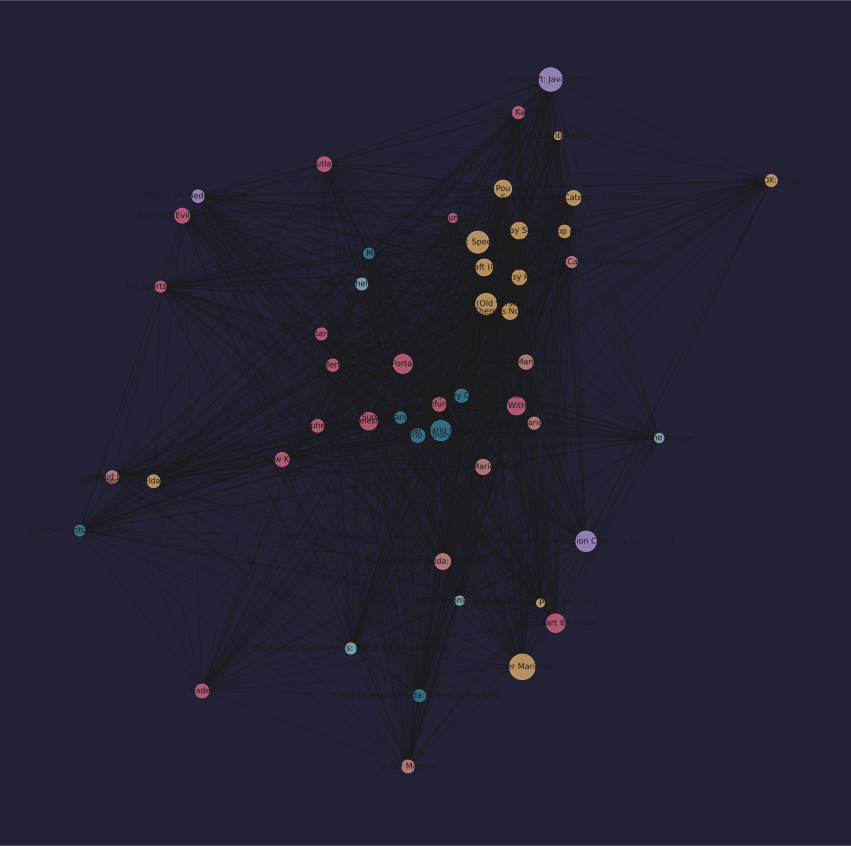

In [6]:


# Communities
communities = list(nx.algorithms.community.modularity_max.greedy_modularity_communities(G, weight='weight', resolution=1.5))

# Global layout
global_pos = nx.spring_layout(G, weight='weight', k = 1, seed = 0)

# Community layouts with blending
community_positions = {}
for community in communities:
    subgraph = G.subgraph(community)
    sub_pos = nx.spectral_layout(subgraph, weight='weight')  # Tighter clustering within communities

    for node in community:
        # Blend global and local positions
        community_positions[node] = 0.48 * global_pos[node] + 0.52 * sub_pos[node]

def nudge_nodes(positions, min_dist=1, max_iter=100):
    """
    Nudges nodes to reduce overlap based on minimum distance.
    """
    nodes = list(positions.keys())
    pos_array = np.array([positions[node] for node in nodes])
    min_dist_squared = min_dist ** 2  # Avoid frequent sqrt for distance checks

    for iteration in range(max_iter):
        has_overlap = False
        for i, pos1 in enumerate(pos_array):
            for j, pos2 in enumerate(pos_array):
                if i >= j:
                    continue

                delta = pos2 - pos1
                dist_squared = np.dot(delta, delta)
                if dist_squared < min_dist_squared:  # Overlap detected
                    has_overlap = True
                    norm = np.sqrt(dist_squared) if dist_squared > 0 else 1
                    push = (min_dist - norm) / 2
                    direction = delta / norm if norm > 0 else np.random.rand(2) - 0.5
                    pos_array[i] -= direction * push
                    pos_array[j] += direction * push

        if not has_overlap:
            break  # Stop early if no overlap

    return {node: pos_array[i] for i, node in enumerate(nodes)}

# Adjust positions to resolve overlaps
community_positions = nudge_nodes(community_positions, min_dist=0.05, max_iter=500)


# Draw the graph
plt.figure(figsize=(15, 15))

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(
        G,
        community_positions,
        nodelist=community,
        node_size=[scaled_node_sizes[game] for game in community],
        node_color=f'C{i}',
        alpha=0.7
    )

nx.draw_networkx_edges(G, community_positions, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, community_positions, font_size=8, font_color='k')

plt.axis('off')
plt.show()


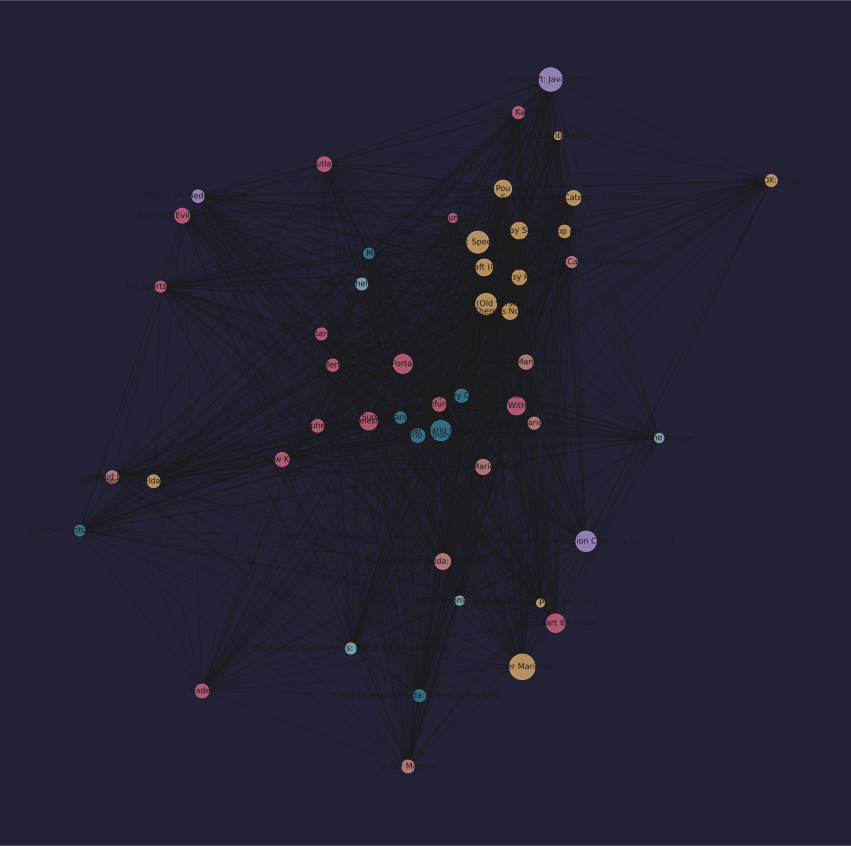

In [7]:
# Modify manually the coordinates of Minecraft: Java Edition, Minecraft: Bedrock Edition, Minecraft: Java Edition Category Extensions to make them closer to each other
mean_graph = np.mean([community_positions[game] for game in community_positions], axis=0)
for idd in [36,19, 21, 40, 20, 7, 37, 4]:
    pass
    #community_positions[idd] = 0.7 * community_positions[idd] + 0.3 * mean_graph
# community_positions[dic_game_id["Minecraft: Java Edition"]] = 0.7 * community_positions[dic_game_id["Minecraft: Java Edition"]] + 0.3 * mean_graph
# community_positions[dic_game_id["Minecraft: Bedrock Edition"]] = 0.7 * community_positions[dic_game_id["Minecraft: Bedrock Edition"]] + 0.3 * mean_graph
# community_positions[dic_game_id["Minecraft: Java Edition Category Extensions"]] = 0.7 * community_positions[dic_game_id["Minecraft: Java Edition Category Extensions"]] + 0.3 * mean_graph
# community_positions[dic_game_id["CubeCraft Parkour"]] = 0.7 * community_positions[dic_game_id["CubeCraft Parkour"]]+ 0.3 * mean_graph
# community_positions[dic_game_id["Super Mario 64 DS"]] = 0.7 * community_positions[dic_game_id["Super Mario 64 DS"]] + 0.3 * mean_graph
# community_positions[dic_game_id["Splatoon 2"]] = 0.7 * community_positions[dic_game_id["Splatoon 2"]] + 0.3 * mean_graph
# community_positions[dic_game_id["Speed Builders"]] = 0.7 * community_positions[dic_game_id["Speed Builders"]] + 0.3 * mean_graph

# Draw the graph
plt.figure(figsize=(15, 15))


for i, community in enumerate(communities):
    nx.draw_networkx_nodes(
        G,
        community_positions,
        nodelist=community,
        node_size=[scaled_node_sizes[game] for game in community],
        node_color=f'C{i}',
        alpha=0.7
    )

nx.draw_networkx_edges(G, community_positions, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, community_positions, font_size=8, font_color='k')

plt.axis('off')
plt.show()



In [8]:
# List all games per community
for i, community in enumerate(communities):
    print(f"Community {i}: {[dic_id_game[id] for id in community]}")

Community 0: ['Spelunky 2', 'Undertale', 'Resident Evil 2 (2019)', 'Portal', 'Deltarune', 'Hollow Knight', 'Outlast', 'Celeste', 'Refunct', 'Getting Over It With Bennett Foddy', 'Cuphead', 'Hades']
Community 1: ['Hill Climb Racing', 'ROBLOX: Speed Run 4', 'ROBLOX: Piggy', 'Minecraft (Classic)', 'Pou', 'Crossy Road', 'White Tiles 4: Piano Master 2', 'There Is No Game', 'Bhop pro', 'Seterra (Old Version)', 'Subway Surfers']
Community 2: ['Metroid Dread', 'Super Mario World', 'Super Mario Bros.', 'Super Mario Bros. Category Extensions', 'Super Metroid', 'Super Mario Bros. 3', 'The Legend of Zelda: A Link to the Past']
Community 3: ['Sonic Adventure 2: Battle', 'Super Mario Odyssey Category Extensions', 'Super Mario Odyssey', 'Super Mario Galaxy', 'The Legend of Zelda: Breath of the Wild', "Luigi's Mansion", 'Super Mario Sunshine']
Community 4: ['Spyro the Dragon', 'Grand Theft Auto V', 'SpongeBob SquarePants: Battle for Bikini Bottom', 'The Simpsons: Hit & Run']
Community 5: ['Minecraft: 

In [9]:
# Add node position (x,y) and community to the nodes
graph_data["nodes"] = [{"id": node['id'], "name": node['name'], "players": int(node_sizes[node['id']]), "size": int(round(scaled_node_sizes[node['id']])), "x": community_positions[node['id']][0], "y": community_positions[node['id']][1], "community": next(int(i) for i, community in enumerate(communities) if node['id'] in community)} for i, node in enumerate(graph_data["nodes"])] 

# Cast the edge weights to integers
graph_data["edges"] = [{"source": edge["source"], "target": edge["target"], "weight": int(edge["weight"]), "scaled_egde_weight": int(round(edge["scaled_egde_weight"]))} for edge in graph_data["edges"]]


# Shift all nodes to be in the positive quadrant
min_x = min([node["x"] for node in graph_data["nodes"]])
min_y = min([node["y"] for node in graph_data["nodes"]])
graph_data["nodes"] = [{"id": node["id"], "name": node["name"], "players": node["players"], "size": node["size"], "x": node["x"] - min_x, "y": node["y"] - min_y, "community": node["community"]} for node in graph_data["nodes"]]
graph_data["edges"] = [{"source": edge["source"], "target": edge["target"], "weight": edge["weight"], "scaled_egde_weight": edge["scaled_egde_weight"]} for edge in graph_data["edges"]]

# Multiply all node positions by 100 
graph_data["nodes"] = [{"id": node["id"], "name": node["name"], "players": node["players"], "size": node["size"], "x": node["x"] * 100, "y": node["y"] * 100, "community": node["community"]} for node in graph_data["nodes"]]
graph_data["edges"] = [{"source": edge["source"], "target": edge["target"], "weight": edge["weight"], "scaled_egde_weight": edge["scaled_egde_weight"]} for edge in graph_data["edges"]]


In [10]:

# Reorganize the nodes so that they are stored by community in graph_data
l_sorted_nodes = []
for i, community in enumerate(communities):
    l_sorted_nodes += [node for node in graph_data["nodes"] if node["community"] == i]
graph_data["nodes"] = l_sorted_nodes


In [11]:
l_categories = ["Indie and Challenging", "Casual and Mobile", "Classic and Retro", "3D Platformers and Open World", "Action", "Minecraft Versions", "Racing and Sports", "Classic 3D Platformers"]
# Add categories to graph_data
graph_data["categories"] = [{"id": i, "name": community} for i, community in enumerate(l_categories)]

# Rename community to category in nodes
graph_data["nodes"] = [{"id": node["id"], "name": node["name"], "players": node["players"], "size": node["size"], "x": node["x"], "y": node["y"], "category": node["community"]} for node in graph_data["nodes"]]

In [12]:
# Save the graph data as a json file
with gzip.open("/Users/cdroin/Library/CloudStorage/GoogleDrive-colasdroin@gmail.com/Mon Drive/Data_viz/speedruns/app/public/data/network_data.json.gz", "wt") as f:
    json.dump(graph_data, f)
    
# Save the graph data as a json file
with open("/Users/cdroin/Library/CloudStorage/GoogleDrive-colasdroin@gmail.com/Mon Drive/Data_viz/speedruns/app/public/data/network_data.json", "w") as f:
    json.dump(graph_data, f)

In [13]:
graph_data["nodes"]

[{'id': 'Celeste',
  'name': 'Celeste',
  'players': 2630,
  'size': 311,
  'x': 61.546572919283804,
  'y': 65.66006045837476,
  'category': 0},
 {'id': 'Deltarune',
  'name': 'Deltarune',
  'players': 1003,
  'size': 148,
  'x': 51.48169286419901,
  'y': 82.25158806563556,
  'category': 0},
 {'id': 'Getting Over It With Bennett Foddy',
  'name': 'Getting Over It With Bennett Foddy',
  'players': 2820,
  'size': 330,
  'x': 93.02133843336276,
  'y': 68.56743074317605,
  'category': 0},
 {'id': 'Outlast',
  'name': 'Outlast',
  'players': 1709,
  'size': 218,
  'x': 52.073501608409956,
  'y': 114.52974262435288,
  'category': 0},
 {'id': 'Portal',
  'name': 'Portal',
  'players': 3206,
  'size': 368,
  'x': 68.81528236661374,
  'y': 76.55475318913098,
  'category': 0},
 {'id': 'Refunct',
  'name': 'Refunct',
  'players': 1489,
  'size': 196,
  'x': 76.57856795664668,
  'y': 68.87505954437194,
  'category': 0},
 {'id': 'Undertale',
  'name': 'Undertale',
  'players': 1068,
  'size': 154,

In [14]:
graph_data["edges"]

[{'source': 'Bhop pro',
  'target': 'Celeste',
  'weight': 5,
  'scaled_egde_weight': 5},
 {'source': 'Bhop pro',
  'target': 'Crossy Road',
  'weight': 53,
  'scaled_egde_weight': 43},
 {'source': 'Bhop pro',
  'target': 'Deltarune',
  'weight': 5,
  'scaled_egde_weight': 5},
 {'source': 'Bhop pro',
  'target': 'Getting Over It With Bennett Foddy',
  'weight': 7,
  'scaled_egde_weight': 7},
 {'source': 'Bhop pro',
  'target': 'Grand Theft Auto V',
  'weight': 2,
  'scaled_egde_weight': 2},
 {'source': 'Bhop pro',
  'target': 'Hill Climb Racing',
  'weight': 19,
  'scaled_egde_weight': 17},
 {'source': 'Bhop pro',
  'target': 'Mario Kart 8 Deluxe',
  'weight': 8,
  'scaled_egde_weight': 8},
 {'source': 'Bhop pro',
  'target': 'Mario Kart Wii',
  'weight': 2,
  'scaled_egde_weight': 2},
 {'source': 'Bhop pro',
  'target': 'Minecraft (Classic)',
  'weight': 35,
  'scaled_egde_weight': 30},
 {'source': 'Bhop pro',
  'target': 'Minecraft: Bedrock Edition',
  'weight': 6,
  'scaled_egde_wei